In [1]:
import scanpy as sc
import pandas as pd
from pathlib import Path
import anndata as ad
import numpy as np
import os
import scvi

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

Global seed set to 0


In [2]:
DIR2SAVE = Path(
    "/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/subpopulations/Myeloid/final/"
)
DIR2SAVE.mkdir(parents=True, exist_ok=True)

In [3]:
DIR2LOAD = Path(
    "/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/subpopulations/Myeloid/scvi_latent20/alternative_version"
)

In [4]:
FIG2SAVE = DIR2SAVE.joinpath("figures/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [5]:
adata_myeloid = sc.read_h5ad(
    DIR2LOAD.joinpath(
        "Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_Myeloid_clustering_annotations.h5ad"
    )
)
adata_dc = sc.read_h5ad(
    DIR2LOAD.joinpath("Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_DC_clustering.h5ad")
)

adata_C1QC_PLTP_IL1B = sc.read_h5ad(
    DIR2LOAD.joinpath(
        "Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_C1QC_PLTP_IL1B_clustering.h5ad"
    )
)

In [6]:
adata_myeloid.obs.Annotation_scVI_detailed.value_counts()

SPP1 Mac              4619
Neutrophil            2892
NLRP3 Mac             2075
DC                    2017
C1QC-PLTP-IL1B Mac    1739
C1QC Mac              1397
FCN1 Mono              999
Kupffer                600
Myeloid cycling        513
HSP Mono               387
Name: Annotation_scVI_detailed, dtype: int64

In [8]:
adata_dc.obs.Annotation_scVI_detailed_DC.value_counts()

cDC2     1543
pDC       239
cDC1      163
migDC      72
Name: Annotation_scVI_detailed_DC, dtype: int64

In [9]:
adata_C1QC_PLTP_IL1B.obs.Annotation_scVI_detailed_C1QC_PLTP_IL1B.value_counts()

C1QC Mac          609
PLTP LYVE1 Mac    574
IL1B Mac          550
Name: Annotation_scVI_detailed_C1QC_PLTP_IL1B, dtype: int64

### Add DC annotations first 

In [10]:
# add DC annotations to adata_myeloid object by merging
adata_myeloid.obs = adata_myeloid.obs.merge(
    adata_dc.obs[["Annotation_scVI_detailed_DC"]],
    how="left",
    left_index=True,
    right_index=True,
    suffixes=("", "_DC"),
)

In [11]:
adata_myeloid.obs

,Patient,Sample,Cell_type,Cell_subtype,Tissue,Therapy,doublet_score,n_genes_by_counts,total_counts,pct_counts_mt,...,G2M_score,phase,cell_cycle_diff,_scvi_batch,_scvi_labels,leiden_scVI,leiden_scVI_r1.5,leiden_scVI_r1,Annotation_scVI_detailed,Annotation_scVI_detailed_DC
CRC01_LM#AAACATGCATCAGCAC-1-BCI-Nuclei,CRC01,CRC01_LM,Myeloid,No annotation,LM,NAC,0.001115,727,981.0,3.771662,...,-0.056709,G1,-0.032901,0,0,5,5,2,SPP1 Mac,NaN
CRC01_LM#AACATAGCAGGATAAC-1-BCI-Nuclei,CRC01,CRC01_LM,Myeloid,No annotation,LM,NAC,0.002359,365,461.0,1.301518,...,-0.061650,G1,0.016243,0,0,5,5,2,SPP1 Mac,NaN
CRC01_LM#CTAAGGTTCCTTGCGT-1-BCI-Nuclei,CRC01,CRC01_LM,Myeloid,No annotation,LM,NAC,0.000588,1750,2828.0,2.157001,...,-0.143599,G1,-0.031434,0,0,10,9,3,SPP1 Mac,NaN
CRC01_LM#CTTGTAAAGTCAATCA-1-BCI-Nuclei,CRC01,CRC01_LM,Myeloid,No annotation,LM,NAC,0.000482,1398,2094.0,0.525310,...,-0.182749,G1,0.094150,0,0,5,5,2,SPP1 Mac,NaN
CRC01_LM#GATCCGTCAAATGCCC-1-BCI-Nuclei,CRC01,CRC01_LM,Myeloid,No annotation,LM,NAC,0.001481,842,1117.0,0.537153,...,-0.031695,G1,0.023181,0,0,10,9,2,SPP1 Mac,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P20_Liver_T_TTCTTCCCAGCAGTAG-1-Wu-Cells,Wu2021_P20,P20_Liver_T,Myeloid,MRC1+ M2-like Macrophage,LM,NAC,0.173145,1998,6314.0,2.993348,...,-0.060213,G1,0.039463,0,0,2,3,0,C1QC-PLTP-IL1B Mac,NaN
P20_Liver_T_TTGGATGGTTACGTAC-1-Wu-Cells,Wu2021_P20,P20_Liver_T,Myeloid,MRC1+ M2-like Macrophage,LM,NAC,0.187970,1488,4259.0,6.010800,...,0.025690,G2M,-0.084584,0,0,2,3,0,C1QC-PLTP-IL1B Mac,NaN
P20_Liver_T_TTGTGGAAGGTTCCAT-1-Wu-Cells,Wu2021_P20,P20_Liver_T,Myeloid,SPP1+ Activated Macrophage,LM,NAC,0.119565,2751,11502.0,1.434533,...,-0.057147,G1,0.019549,0,0,15,8,5,SPP1 Mac,NaN
P20_Liver_T_TTTACCATCGATTTCT-1-Wu-Cells,Wu2021_P20,P20_Liver_T,Myeloid,SPP1+ Activated Macrophage,LM,NAC,0.187970,4104,22801.0,2.030613,...,-0.087496,G1,0.030584,0,0,15,8,5,SPP1 Mac,NaN


Notice that col `Annotation_scVI_detailed_DC` has NaN values for myeloid cell annotation, need to fill the nan with myeloid cell annotations from `Annotation_scVI_detailed`

In [12]:
adata_myeloid.obs.Annotation_scVI_detailed_DC = np.where(
    adata_myeloid.obs.Annotation_scVI_detailed_DC.isna(),  # where NaN values in DC annot
    adata_myeloid.obs.Annotation_scVI_detailed,  # put Myeloid annotations
    adata_myeloid.obs.Annotation_scVI_detailed_DC,
)  # keep DC annotations

adata_myeloid.obs.Annotation_scVI_detailed_DC = (
    adata_myeloid.obs.Annotation_scVI_detailed_DC.astype("category")
)

In [14]:
adata_myeloid.obs.drop(
    columns="Annotation_scVI_detailed", inplace=True
)  # drop annotations

In [15]:
# rename annotations column
adata_myeloid.obs.rename(
    columns={"Annotation_scVI_detailed_DC": "Annotation_scVI_detailed"}, inplace=True
)

### Add C1QC-PLTP-IL1B mac annotations

In [17]:
adata_myeloid.obs = adata_myeloid.obs.merge(
    adata_C1QC_PLTP_IL1B.obs[["Annotation_scVI_detailed_C1QC_PLTP_IL1B"]],
    how="left",
    left_index=True,
    right_index=True,
    suffixes=("", "_IL1B"),
)

In [19]:
adata_myeloid.obs.Annotation_scVI_detailed_C1QC_PLTP_IL1B = np.where(
    adata_myeloid.obs.Annotation_scVI_detailed_C1QC_PLTP_IL1B.isna(),  # where NaN values in DC annot
    adata_myeloid.obs.Annotation_scVI_detailed,  # put Myeloid annotations
    adata_myeloid.obs.Annotation_scVI_detailed_C1QC_PLTP_IL1B,
)  # keep annotations

adata_myeloid.obs.Annotation_scVI_detailed_C1QC_PLTP_IL1B = (
    adata_myeloid.obs.Annotation_scVI_detailed_C1QC_PLTP_IL1B.astype("category")
)

In [21]:
adata_myeloid.obs.drop(
    columns="Annotation_scVI_detailed", inplace=True
)  # drop annotations

In [22]:
# rename annotations column
adata_myeloid.obs.rename(
    columns={"Annotation_scVI_detailed_C1QC_PLTP_IL1B": "Annotation_scVI_detailed"},
    inplace=True,
)

### Colours for plot

In [24]:
adata_myeloid.obs.Annotation_scVI_detailed.cat.categories.tolist()

['C1QC Mac',
 'C1QC-PLTP-IL1B Mac',
 'FCN1 Mono',
 'HSP Mono',
 'IL1B Mac',
 'Kupffer',
 'Myeloid cycling',
 'NLRP3 Mac',
 'Neutrophil',
 'PLTP LYVE1 Mac',
 'SPP1 Mac',
 'cDC1',
 'cDC2',
 'migDC',
 'pDC']

### remove cells that were not annotated in C1QC-PLTP-IL1B Mac because of too few cells per patient

In [25]:
adata_myeloid[adata_myeloid.obs.Annotation_scVI_detailed == "C1QC-PLTP-IL1B Mac"].obs

,Patient,Sample,Cell_type,Cell_subtype,Tissue,Therapy,doublet_score,n_genes_by_counts,total_counts,pct_counts_mt,...,S_score,G2M_score,phase,cell_cycle_diff,_scvi_batch,_scvi_labels,leiden_scVI,leiden_scVI_r1.5,leiden_scVI_r1,Annotation_scVI_detailed
CRC13_LM#ATGGCCCAGCTACTGG-1-BCI-Nuclei,CRC13,CRC13_LM,Myeloid,No annotation,LM,NAC,0.079883,2535,5488.0,3.006560,...,-0.129163,-0.168469,G1,0.039306,0,0,2,5,0,C1QC-PLTP-IL1B Mac
CRC13_LM#CGAAGCGAGCTTGCTC-1-BCI-Nuclei,CRC13,CRC13_LM,Myeloid,No annotation,LM,NAC,0.002684,2039,4521.0,9.909312,...,0.008541,-0.112252,S,0.120793,0,0,2,3,0,C1QC-PLTP-IL1B Mac
CRC14_LM#GCAAGCCTCGTTAGTA-1-BCI-Nuclei,CRC14,CRC14_LM,Myeloid,No annotation,LM,NAC,0.010875,1200,2014.0,9.582920,...,-0.084392,-0.032924,G1,-0.051469,0,0,2,3,0,C1QC-PLTP-IL1B Mac
CRC14_LM#TCTACCTCATGAGTTT-1-BCI-Nuclei,CRC14,CRC14_LM,Myeloid,No annotation,LM,NAC,0.001595,1697,2941.0,0.340020,...,-0.145124,-0.049014,G1,-0.096109,0,0,2,3,0,C1QC-PLTP-IL1B Mac
P3_Liver_T_GATGCTAGTCAAGGCA-Wu-Cells,Wu2021_P3,P3_Liver_T,Myeloid,MRC1+ M2-like Macrophage,LM,naive,0.151515,3922,19121.0,2.573087,...,-0.065213,-0.060567,G1,-0.004646,0,0,2,3,0,C1QC-PLTP-IL1B Mac
P3_Liver_T_GTTTACTGTGCATTTG-Wu-Cells,Wu2021_P3,P3_Liver_T,Myeloid,MRC1+ M2-like Macrophage,LM,naive,0.112329,1791,6237.0,1.042168,...,-0.040015,-0.063524,G1,0.023509,0,0,2,3,0,C1QC-PLTP-IL1B Mac


In [26]:
adata_myeloid = adata_myeloid[
    adata_myeloid.obs.Annotation_scVI_detailed != "C1QC-PLTP-IL1B Mac"
].copy()

In [27]:
adata_myeloid.obs.Annotation_scVI_detailed.cat.categories.tolist()

['C1QC Mac',
 'FCN1 Mono',
 'HSP Mono',
 'IL1B Mac',
 'Kupffer',
 'Myeloid cycling',
 'NLRP3 Mac',
 'Neutrophil',
 'PLTP LYVE1 Mac',
 'SPP1 Mac',
 'cDC1',
 'cDC2',
 'migDC',
 'pDC']

In [28]:
adata_myeloid.uns["Annotation_scVI_detailed_colors"] = [
    "#80b1d3",
    "#b3de69",
    "#e31a1c",
    "#fb8072",
    "#e78ac3",
    "#ffff99",
    "#fdb462",
    "#1f78b4",
    "#fccde5",
    "#8dd3c7",
    "#bc80bd",
    "#bebada",
    "#762a83",
    "#fa9fb5",
]

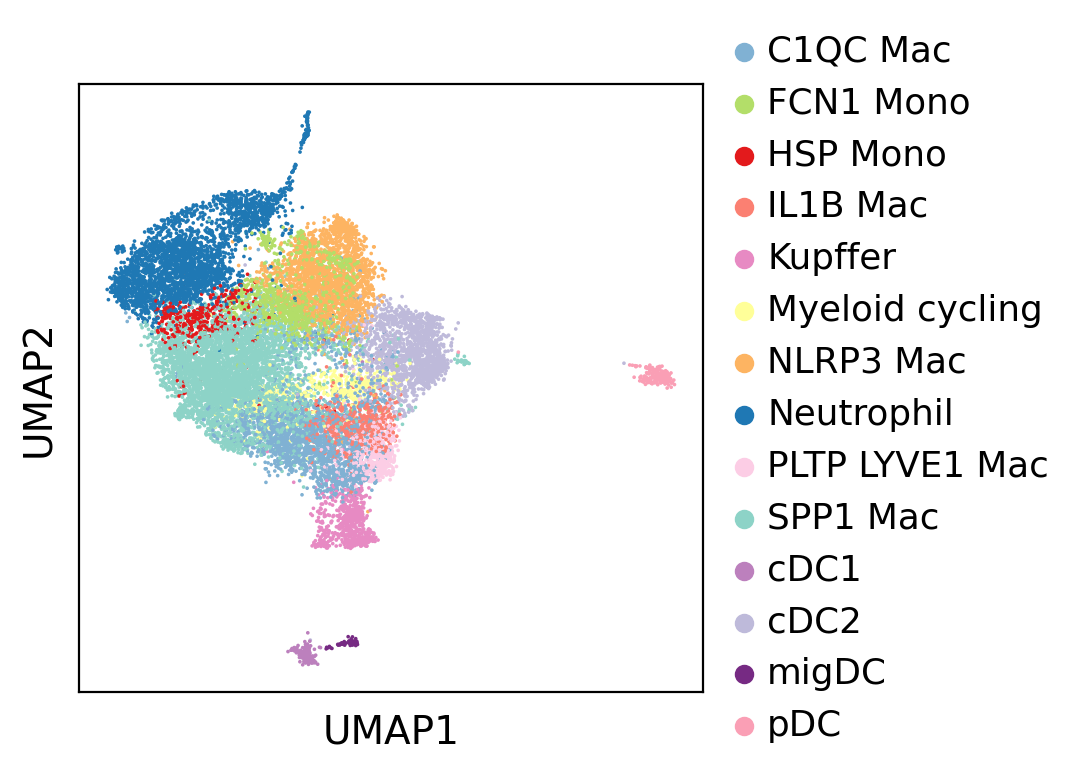

In [30]:
sc.pl.umap(
    adata_myeloid,
    color="Annotation_scVI_detailed",
    show=True,
    legend_loc="right margin",
    save="annotations_final.pdf",
    title="",
)

In [37]:
# save object
# write to file
adata_myeloid.write(
    DIR2SAVE.joinpath("CRC_LM_decon_scvi_hvg_Myeloid_DC_clustering_final.h5ad")
)

#### Barplots chemotreated vs naive in metastasis 

In [42]:
from matplotlib.patches import Rectangle


def proportion_cells_patient(
    adata, groupby_labels, xlabel: str, ylabel: str, plot2save, colors: dict
):  # colors
    # compute proportion of cells within each group
    table2plot = (
        adata.reset_index()
        .groupby(groupby_labels)
        .size()
        .groupby(level=0)
        .apply(lambda x: x * 100 / x.sum())
        .unstack()
    )

    fig, ax = plt.subplots(
        nrows=1, ncols=1, sharey=False, sharex=False, dpi=DPI
    )  # , figsize=(4, 4))

    print(table2plot)

    table2plot.plot.bar(stacked=True, ax=ax, color=colors.values())  # , color=colors

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.grid(False, which="major", axis="both")  # removes major horizontal gridlinesd

    labels = list(colors.keys())

    l = [Rectangle((0, 0), 0, 0, color=color) for color in list(colors.values())]

    ax.legend(
        l,
        labels,
        loc="upper left",
        bbox_to_anchor=(1, 0.8),
        facecolor="white",
        edgecolor="white",
        ncol=1,
        borderaxespad=0.0,
        framealpha=0,
        frameon=False,
    )

    plt.savefig(
        plot2save,
        dpi=DPI,
        format="png",
        facecolor="w",
        transparent=True,
        edgecolor="w",
        # orientation='landscape'
    )

    plt.show()

In [43]:
from collections import OrderedDict

color_dict = OrderedDict(
    zip(
        adata_myeloid.obs["Annotation_scVI_detailed"].cat.categories.values.tolist(),
        adata_myeloid.uns["Annotation_scVI_detailed_colors"],
    )
)

Annotation_scVI_detailed   C1QC Mac  FCN1 Mono  HSP Mono  IL1B Mac   Kupffer  \
Therapy                                                                        
NAC                       10.632849   5.229676  1.206213  3.734303  4.453073   
naive                     14.021061   7.137285  4.699688  1.911076  1.189548   

Annotation_scVI_detailed  Myeloid cycling  NLRP3 Mac  Neutrophil  \
Therapy                                                            
NAC                              2.941176  14.367151   20.373430   
naive                            3.061622   6.552262    8.307332   

Annotation_scVI_detailed  PLTP LYVE1 Mac   SPP1 Mac      cDC1       cDC2  \
Therapy                                                                    
NAC                             4.221745  19.910773  1.074025  10.756775   
naive                           1.228549  43.077223  0.643526   4.699688   

Annotation_scVI_detailed     migDC       pDC  
Therapy                                       
NAC    

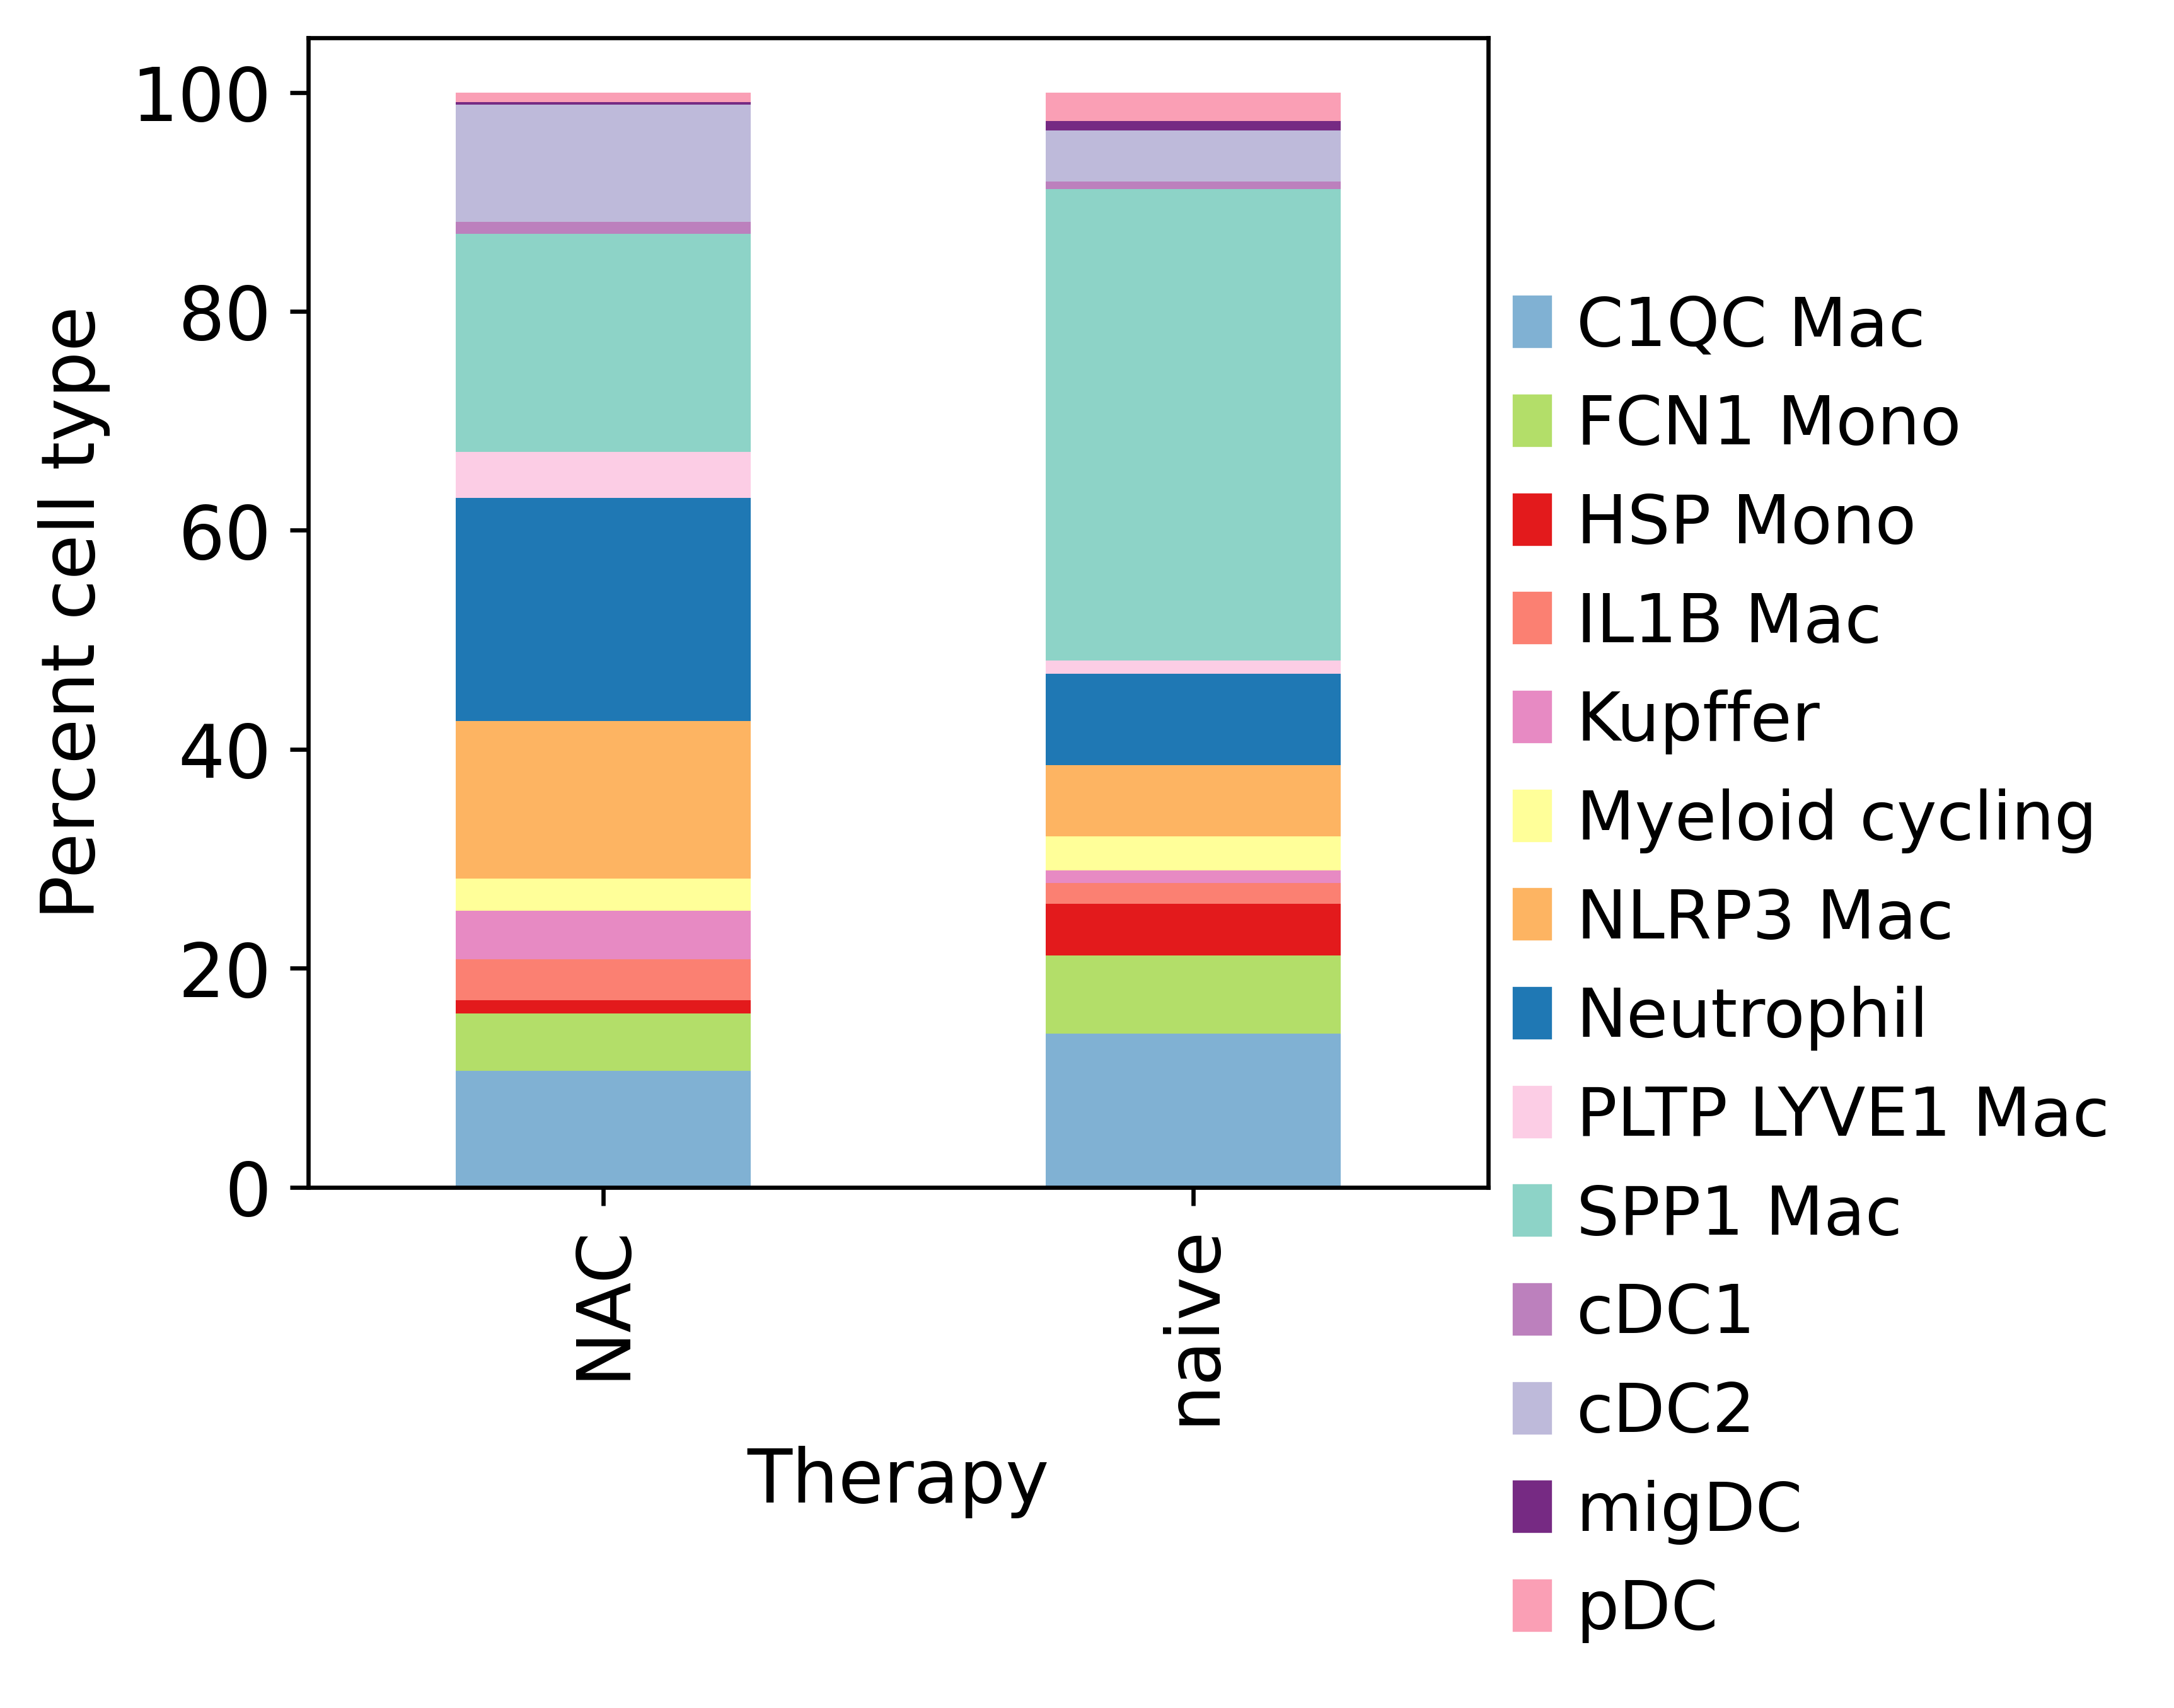

In [44]:
proportion_cells_patient(
    adata_myeloid.obs,
    groupby_labels=["Therapy", "Annotation_scVI_detailed"],
    xlabel="Therapy",
    ylabel="Percent cell type",
    colors=color_dict,
    plot2save=FIG2SAVE.joinpath("Barplot_therapy_celltypes.png"),
)